# **`word2vec` Training Workflow**
In this workflow, we first train `word2vec` models across years using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether models from earlier years are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen our hyperparameters, we use them to train models for every year from 1900 through 2019.

## **Setup**
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from ngramkit.ngram_train.word2vec import build_word2vec_models, evaluate_word2vec_models, plot_evaluation_results
from ngramkit.ngram_train.word2vec import run_regression_analysis, plot_regression_results
from ngramkit.ngram_train.word2vec.normalize_and_align_models import normalize_and_align_vectors

### Configure

In [2]:
db_path_stub = '/scratch/edk202/NLP_corpora/Google_Books/'
release = '20200217'
language = 'eng'
size = 5

## **Test Model Hyperparameters**
### Train Models
Here we test models from 1900 tp 2015 in 5-year increments, cycling through a range of reasonable hyperparameters. In this workflow, we constrain our grid search as follows:
1. We stick to the Skip-Gram (`skip-gram`) approach. Skip-gram is known to be more efficient than Continuous Bag of Words (`CBOW`) for Google n-gram data.
2. We test vector dimensions (`vector_size`) from 100 to 300. Our vocabulary is probably too small to support the extraction of more than 300 meaningful features.
3. We test training epochs (`epochs`) from 5 to 30. More than 30 epochs risks overfitting.
4. We set the minimum word count (`min_count`) to 1, meaning that no words will be excluded from training. Our whitelist ensures that all vocabulary words appear frequently in every corpus from 1900 to 2015.
5. Weighting (`weight_by`) is set to none. `word2vec` already downweights extremely frequent words.
6. We set a context window (`window`) of 4. This width extracts as much context as possible from 5-grams.

In [3]:
build_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    years=(1900, 2015),
    year_step=5,
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(5, 10, 15, 20, 25, 30),
    max_parallel_models=48,
    workers_per_model=2,
    mode="resume",
    unk_mode="retain",
    use_corpus_file=True,
    cache_corpus=True
);


Scanning for existing models...


Scanning existing models: 100%|██████████| 395/395 [00:08<00:00, 45.09 files/s]

  Valid models found:    395
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-21 06:51:00

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Log directory:        .../edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training
Parallel models:      48

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2015 (step=5, 24 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training e

  Created corpus file for year 1995, weight_by=none: /state/partition1/job-527109/w2v_corpus_y1995_wbnone_hdsr_pnv.txt
  Created corpus file for year 2015, weight_by=none: /state/partition1/job-527109/w2v_corpus_y2015_wbnone_u6uamwq7.txt
  Created corpus file for year 2010, weight_by=none: /state/partition1/job-527109/w2v_corpus_y2010_wbnone_o_00n_yw.txt
  Created corpus file for year 2000, weight_by=none: /state/partition1/job-527109/w2v_corpus_y2000_wbnone_2shgqa4l.txt
  Created corpus file for year 2005, weight_by=none: /state/partition1/job-527109/w2v_corpus_y2005_wbnone_hwfz_ya3.txt



Training Models: 100%|██████████| 37/37 [4:12:25<00:00, 409.33s/ models]   


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       37
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Evaluate Models

Here we evaluate the models we've trained using two "intrinsic" tests: (1) a _similarity test_ assessing how well each model predicts human-rated synonymy judgments, and (2) an _analogy test_ assessing how well each model can answer SAT-style analogy questions. Test results are saved to a CSV file.

Similarity performance is the metric of choice for models intended to track semantic relatedness over time. However, we run both tests here to demonstrate the evaluation code and show that different hyperparameters lend themselves to different performance metrics.

In [4]:
evaluate_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=True,
    workers=100
);


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-21 11:47:52

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Evaluation file:      ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
Log directory:        ...dk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 432 models to evaluate



Evaluating models: 100%|██████████| 432/432 [1:23:10<00:00, 11.55s/ models]  



Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     432
Results saved to:     ...LP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



'/scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/evaluation_results_test.csv'

### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results

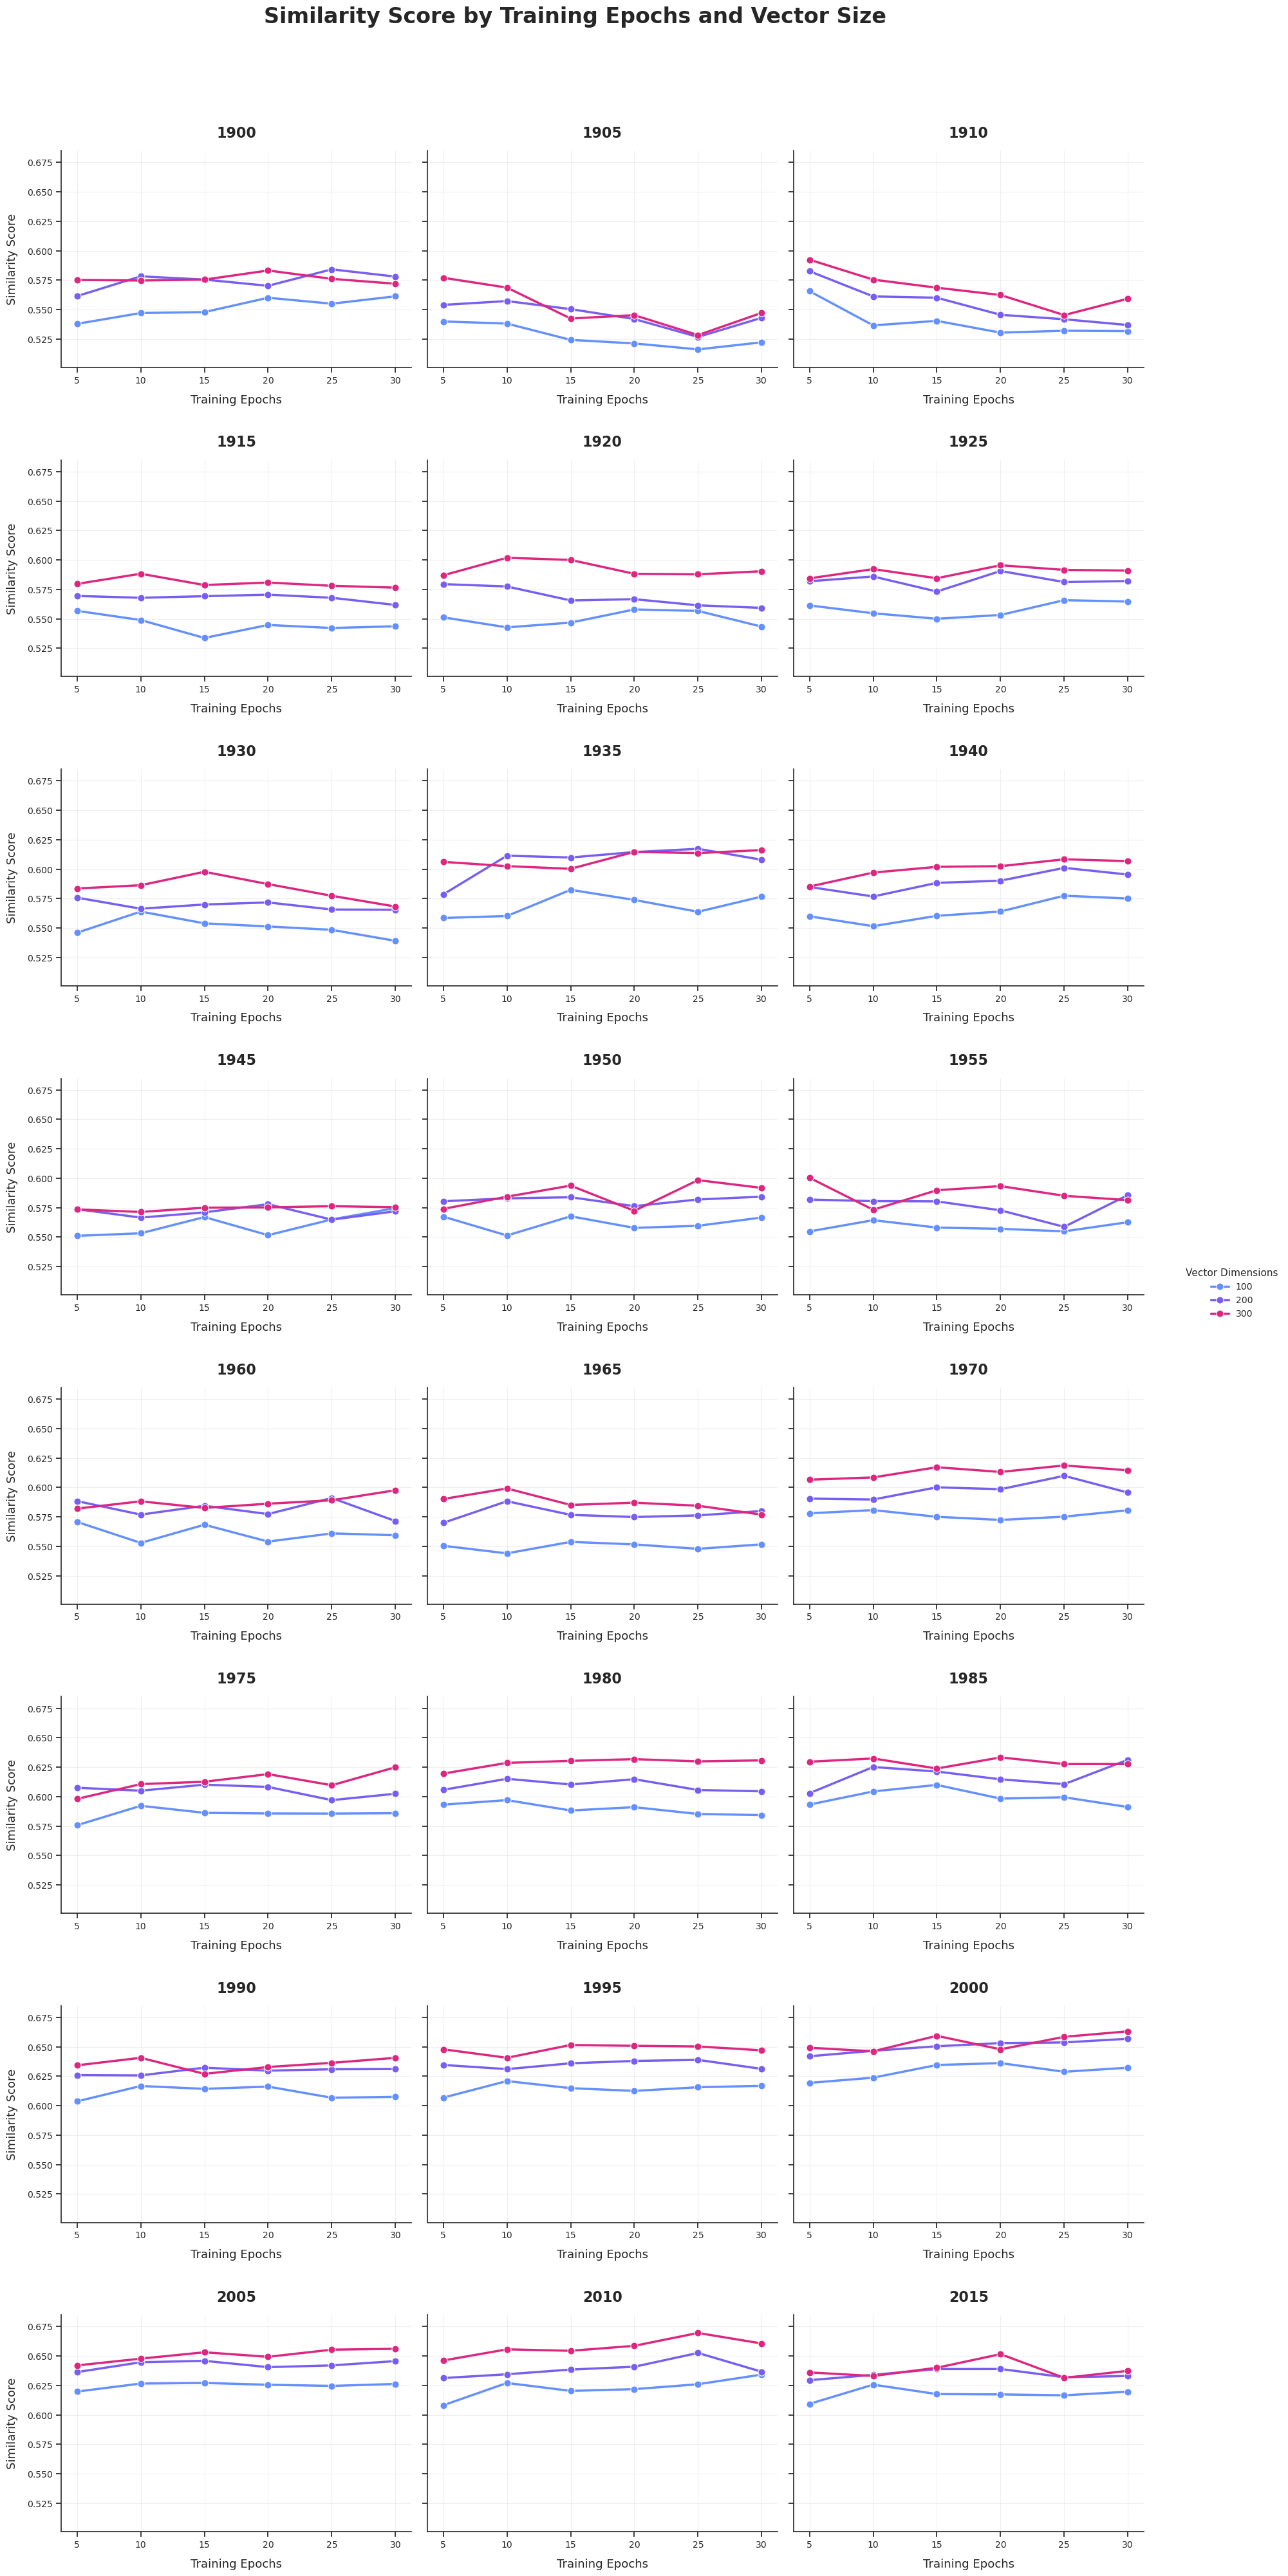

In [5]:
plot_evaluation_results(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results

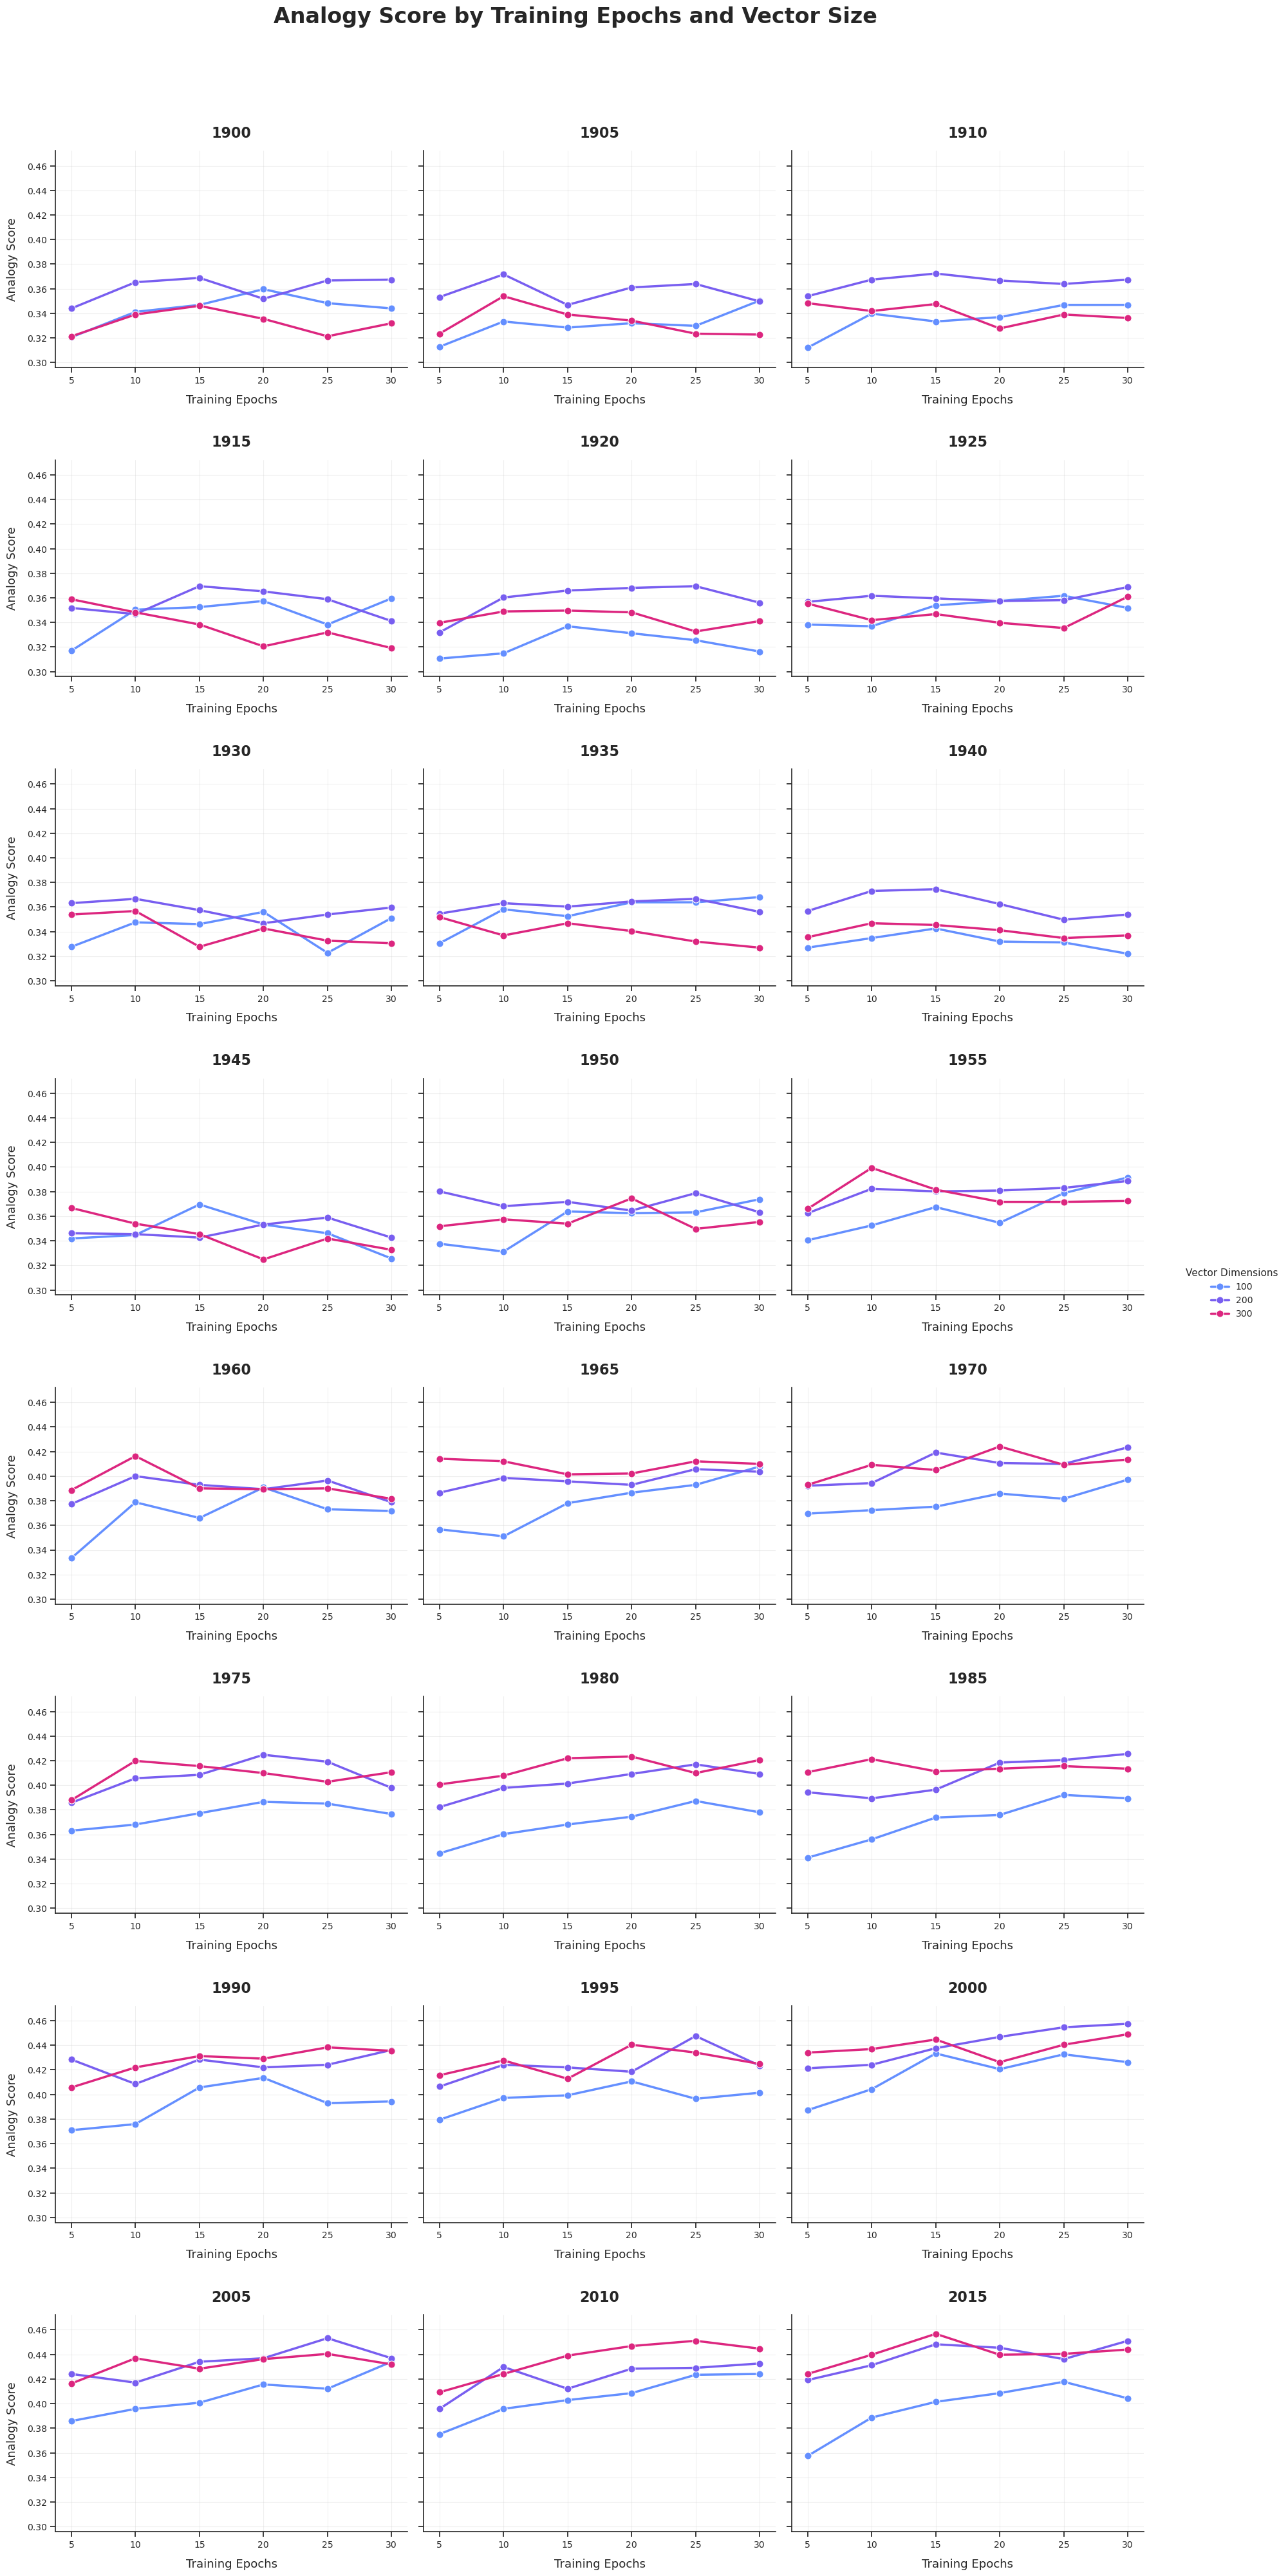

In [6]:
plot_evaluation_results(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs regression analyses on the similarity and analogy results.
#### Predictors of Similarity Performance

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs) + C(approach) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     similarity_score
No. Observations:       432         Method:                 REML            
No. Groups:             24          Scale:                  0.0001          
Min. group size:        18          Log-Likelihood:         1374.2535       
Max. group size:        18          Converged:              Yes             
Mean group size:        18.0                                                
----------------------------------------------------------------------------
                                 Coef.  Std.Err

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


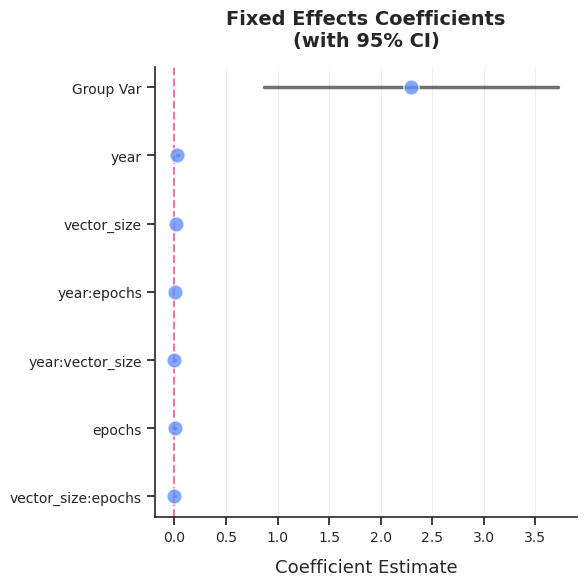

In [7]:
results = run_regression_analysis(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

#### Predictors of Analogy Performance

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: analogy_score ~ scale(year) + scale(vector_size) + scale(epochs) + C(approach) + scale(year):scale(vector_size) + scale(year):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Mixed-effects model failed (Singular matrix). Falling back to OLS regression...
Model converged successfully!

                            OLS Regression Results                            
Dep. Variable:          analogy_score   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     331.4
Date:                Fri, 21 Nov 2025   Prob (F-statistic):          2.61e-144
Time:                        15:00:50   Log-Likelihood:                 1166.2
No. Observations:                 432   AIC:                            -2320.
Df Residuals:                     426   BIC:    

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


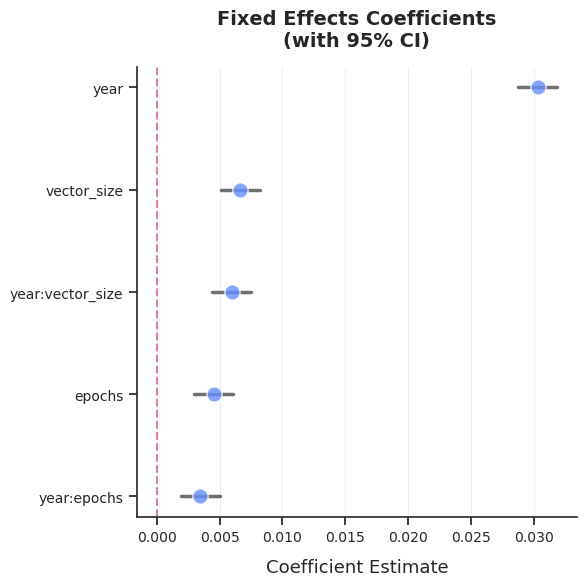

In [8]:
results = run_regression_analysis(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs')],
)

plot_regression_results(results)

## **Train Final Models**

Having explored a range of hyperparameters, we train final models for every year from 1900 through 2019 using what we've learned. A defensible hyperparameter set is:
1. `approach=('skip-gram',)`
2. `window=(4,)`
3. `vector_size=(300,)`
4. `epochs=(10,)`
5. `min_count=1`

In [3]:
build_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='final',
    years=(1900, 2019),
    year_step=1,
    weight_by=('none',),
    vector_size=(300,),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=50,
    workers_per_model=2,
    mode="resume",
    unk_mode="retain",
    use_corpus_file=True
);


Scanning for existing models...
  Valid models found:    0
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-21 18:01:19

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final
Log directory:        ...edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_final/training
Parallel models:      50

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2019 (120 years)
Weighting:            ('none',)
Vector size:          (300,)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gr

Training Models: 100%|██████████| 120/120 [3:17:34<00:00, 98.79s/ models]   


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       120
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



## **Normalize and Align Models**

Before we can use the models for diachronic analysis, we need to unit-normalize the vectors and align them across years using Procrustes rotation. The `normalize_and_align_vectors` function does this.

In [3]:
ngram_size = 5
proj_dir = f'/scratch/edk202/NLP_models/Google_Books/{release}/{language}'
dir_suffix = 'final'
anchor_year = 2019
workers = 32

normalize_and_align_vectors(
    ngram_size=ngram_size,
    proj_dir=proj_dir,
    dir_suffix=dir_suffix,
    anchor_year=anchor_year,
    workers=workers
)

Saved normalized anchor model to /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final/norm_and_align/w2v_y2019_wbnone_vs300_w004_mc001_sg1_e010.kv


Processing models: 100%|██████████| 119/119 [02:24<00:00,  1.21s/file]


Total runtime: 0:02:24.612921
Processed 120 models. Aligned to anchor year 2019.
